In [40]:
import numpy as np
import random
import torch
from matplotlib import pyplot as plt
from math import *

### Define variables

In [41]:
sigma_noise = [2, 2]
image_size = (400, 300)
nbr_inliers=300
nbr_outliers=200
size_patch = (8, 8)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


### Generate Data

In [42]:
def generate_line(image):
    a = int(random.uniform(-10, 10) * 100) / 100
    p = (np.random.randint(image[0]), np.random.randint(image[1]))
    b = p[1] - a*p[0]
    return (a, b)

def compute_line_from_points(p1, p2, image):
    x1, y1 = int(image[0]*p1[0]), int(image[1]*p1[1])
    x2, y2 = int(image[0]*p2[0]), int(image[1]*p2[1])
    if (x2-x1) != 0:
        a = int((y2-y1)/(x2-x1) * 100) / 100
    else:
        a = 100
    b = y1 - a*x1
    return (a, b)
    

def generate_data(line, image, sigma, n_inliers, n_outliers):
    a, b = line
    L_X = []
    L_Y = []
    Points = []
    for x in range(image[0]):
        y = a*x+b
        if y >= 0 and y < image[1]:
            p = np.array([x, y])
            Points.append(p)
    covariance = np.diag(np.array(sigma) ** 2)
    n_i = max(1, n_inliers // len(Points))
    for point in Points:
        sample = np.random.multivariate_normal(point, covariance, n_i)
        sample_X = map(lambda x: int(x)/image[0], sample[:, 0])
        sample_Y = map(lambda x: int(x)/image[1], sample[:, 1])
        L_X.extend(sample_X)
        L_Y.extend(sample_Y)
    
    for k in range(n_outliers):
        (x, y) = (np.random.randint(image[0])/image[0], np.random.randint(image[1])/image[1])
        L_X.append(x)
        L_Y.append(y)
    
    return (L_X, L_Y)

def plot_data(D, ax, c=None):
    L_x, L_y = D
    ax.plot(L_x, L_y, '.', c=c)

def plot_line(line, image, ax, c=None):
    a, b = line
    X = []
    Y = []
    for x in range(image[0]):
        y = a*x+b
        if y >= 0 and y < image[1]:
            X.append(x/image[0])
            Y.append(y/image[1])
    ax.plot(X, Y, c=c)

(-3.44, 210.51999999999998)
72


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


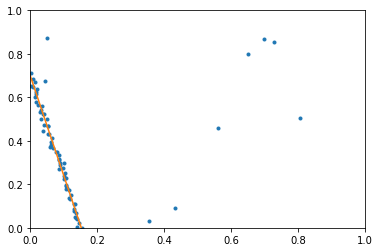

In [43]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
line = generate_line(image_size)
print(line)
D = generate_data(line, image_size, sigma_noise, 100, 10)
plot_data(D, ax)
plot_line(line, image_size, ax)
fig.show()
#print(D)
print(len(D[0]))

### Loss between 2 lines - area

In [44]:
def point_y_in_image(l, x, image_y):
    a, b = l
    y = int(a*x+b)
    y = min(max(y, 0), image_y-1)
    return y

def intersect(l1, l2, image):
    a1, b1 = l1
    a2, b2 = l2
    if a1 == a2:
        return False
    else:
        x = (b2 - b1)/(a1-a2)
        y = a1*x+b1
        if x >= 0 and x < image[0] and y >= 0 and y < image[1]:
            return True
        else:
            return False

def change_sign(l1, l2, image):
    a1, b1 = l1
    a2, b2 = l2
    d1 = b1 - b2
    x = image[0]
    d2 = (a1*x+b1)-(a2*x+b2)
    if d1*d2 < 0:
        return True
    else:
        return False

def loss_weights(l1, l2, image):
    area1 = 0
    for x in range(image[0]):
        y1 = point_y_in_image(l1, x, image[1])
        y2 = point_y_in_image(l2, x, image[1])
        area1 += abs(y1-y2)
    area2 = image[0]*image[1] - area1
    
    inter = intersect(l1, l2, image)
    if inter :
        area = min(area1, area2)
    else:
        sign = change_sign(l1, l2, image)
        if l1[0]*l2[0] <=0 and sign:
            area = area2
        else:
            area = area1
    #print("area final = ", area)
    area = 1 - (area/(image[0]*image[1]))
    return area

def plot_loss(l1, l2, image, ax):
    plot_line(l1, image_size, ax)
    plot_line(l2, image_size, ax)
    area_X = []
    area_Y = []
    area1 = 0
    for x in range(image[0]):
        y1 = point_y_in_image(l1, x, image[1])
        y2 = point_y_in_image(l2, x, image[1])
        area1 += abs(y1-y2)
        for k in range(min(y1, y2), max(y1, y2)):
            area_X.append(x/image[0])
            area_Y.append(k/image[1])
    ax.plot(area_X, area_Y, '.')
    print(area1)
    area2 = image[0]*image[1] - area1
    print(area2)
    
    inter = intersect(l1, l2, image)
    print(inter)
    if inter :
        area = min(area1, area2)
    else:
        sign = change_sign(l1, l2, image)
        print(sign)
        if l1[0]*l2[0] <=0 and sign:
            area = area2
        else:
            area = area1

    area = 1 - (area/(image[0]*image[1])) 
    print("area final = ", area)

    fig.show()

(-9.79, 3259.49)
(-8.37, 2332.75)
16994
103006
False
False
area final =  0.8583833333333333


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


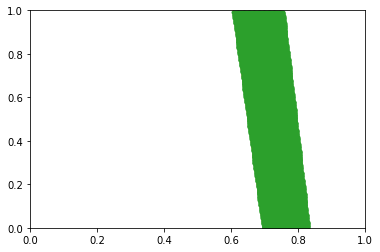

In [45]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
line1 = generate_line(image_size)
print(line1)

line2 = generate_line(image_size)
print(line2)
plot_loss(line1, line2, image_size, ax)

### Loss between 2 lines - distance to inliers

In [46]:
def dist_to_line(p, l, image):
    a, b = l
    x, y = p
    xb, yb = x*image[0], y*image[0]
    d = ((a*xb+b) - yb)/sqrt(1+a*a)
    return d

def dist_points_to_line(data, line, image, n_inliers):
    X, Y = data[0][:n_inliers], data[1][:n_inliers]
    dist = 0
    for i in range(len(X)):
        p = X[i], Y[i]
        dp = dist_to_line(p, line, image)
        dist += dp**2
    return dist

def loss_dist_points(data, line, dist_ref, image, n_inliers):
    dist = dist_points_to_line(data, line, image, n_inliers)
    return dist_ref/dist

### Compute neighborhood

In [47]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return sqrt((x1-x2)**2+(y1-y2)**2)

def reorder(L, M):
    p = L[-1]
    d = M[-1]
    k = len(L) - 2
    while k >= 0 and M[k] > d:
        L[k+1] = L[k]
        M[k+1] = M[k]
        k -= 1
    L[k+1] = p
    M[k+1] = d

def nearest_neighbors(data, i, k):
    p = (data[0][i], data[1][i])
    L = []
    M = []
    n = len(data[0])
    for j in range(n):
        (x, y) = (data[0][j], data[1][j])
        d = dist((x, y), p)
        if len(L) < k:
            L.append((x, y))
            M.append(d)
            reorder(L, M)
        else:
            d2 = M[-1]
            if d < d2:
                L[-1] = (x, y)
                M[-1] = d
                reorder(L, M)
    #print(L)
    return L

def get_neighborhood_patch(data, k, image, size, scale=(1, 1)):
    scale_x, scale_y = scale
    size_x, size_y = size
    n = len(data[0])
    (x, y) = data[0][k]*image[0], data[1][k]*image[1]
    L = [[0]*(2*size_x+1) for _ in range(2*size_y+1)]
    for i in range(n):
        (xb, yb) = data[0][i]*image[0], data[1][i]*image[1]
        dx = xb-x
        if abs(dx) < scale_x/2.:
            lx = 0
        elif dx >=0.5:
            dx = dx - scale_x/2.
            lx = floor(dx/scale_x)+1
        elif dx <= -0.5:
            dx = dx + scale_x/2.
            lx = floor(dx/scale_x)
        lx += size_x
        
        dy = yb-y
        if abs(dy) < scale_y/2.:
            ly = 0
        elif dy >=0.5:
            dy = dy - scale_y/2.
            ly = floor(dy/scale_y)+1
        elif dy <= -0.5:
            dy = dy + scale_y/2.
            ly = floor(dy/scale_y)
        ly += size_y
        
        
        if lx >= 0 and lx < 2*size_x+1 and ly >= 0 and ly < 2*size_y+1:
            L[2*size_y - ly][lx] += 1
            
            
    for i in range(len(L)):
        for j in range(len(L[0])):
            r = L[i][j]
            L[i][j] = [r]
    
    return L

def get_neighbors_radius(data, k, image, radius):
    radius_x, radius_y = radius
    n = len(data[0])
    L = []
    (x, y) = (data[0][k]*image[0], data[1][k]*image[1])
    for i in range(n):
        (xb, yb) = data[0][i]*image[0], data[1][i]*image[1]
        if (abs(xb-x) < radius_x and abs(yb-y) < radius_y):
            L.append([xb, yb])
    return L

In [48]:
line = generate_line(image_size)
data = generate_data(line, image_size, sigma_noise, 200, 50)

In [49]:
def plot_neighborhood_patch(data, k, image, size, scale=(1, 1)):
    scale_x, scale_y = scale
    size_x, size_y = size
    n = len(data[0])
    (x, y) = data[0][k]*image[0], data[1][k]*image[1]
    L = [[0]*(2*size_x+1) for _ in range(2*size_y+1)]
    (L_x, L_y) = ([], [])
    for i in range(n):
        (xb, yb) = data[0][i]*image[0], data[1][i]*image[1]
        dx = xb-x
        if abs(dx) < scale_x/2.:
            lx = 0
        elif dx >=0.5:
            dx = dx - scale_x/2.
            lx = floor(dx/scale_x)+1
        elif dx <= -0.5:
            dx = dx + scale_x/2.
            lx = floor(dx/scale_x)
        lx += size_x
        
        dy = yb-y
        if abs(dy) < scale_y/2.:
            ly = 0
        elif dy >=0.5:
            dy = dy - scale_y/2.
            ly = floor(dy/scale_y)+1
        elif dy <= -0.5:
            dy = dy + scale_y/2.
            ly = floor(dy/scale_y)
        ly += size_y
        
        
        if lx >= 0 and lx < 2*size_x+1 and ly >= 0 and ly < 2*size_y+1:
            L[2*size_y - ly][lx] += 1
            L_x.append(xb)
            L_y.append(yb)
            
            
    for i in range(len(L)):
        for j in range(len(L[0])):
            r = L[i][j]
            L[i][j] = [r]

    return (L_x, L_y, L)

[[0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [2], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [2], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [1], [1], [1], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [2], [1], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [2], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0]]
124.0 260.0
107.5 140.5
243.5 276.5


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


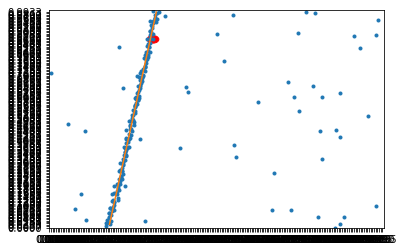

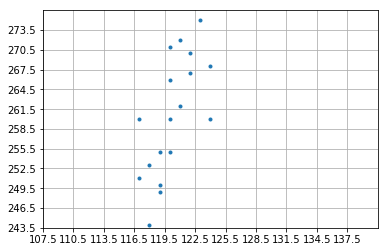

In [50]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.xaxis.set_ticks(np.arange(0, 1, (2./image_size[0])))
ax.yaxis.set_ticks(np.arange(0, 1, (2./image_size[1])))
plot_data(data, ax)
plot_line(line, image_size, ax)
k = np.random.randint(len(data[0]))
scale = (3, 3)
size = (5, 5)
L_x, L_y, L = plot_neighborhood_patch(data, k, image_size, size, scale=scale)
#L = get_neighbors_radius(data, k, image_size, (5, 5))
for x in L:
    print(x)
circle_1 = plt.Circle((data[0][k], data[1][k]), 7./image_size[0], color='r')
px, py = data[0][k]*image_size[0], data[1][k]*image_size[1]
print(px, py)
ax.add_artist(circle_1)
#plt.grid()
fig.show()
#plt.savefig('test.png')

fig2, ax2 = plt.subplots()
(min_x, max_x) = px - (size[0]*scale[0] + scale[0]/2.), px + size[0]*scale[0] + scale[0]/2.
(min_y, max_y) = py - (size[1]*scale[1] + scale[1]/2.), py + size[1]*scale[1] + scale[1]/2.
print(min_x, max_x)
print(min_y, max_y)
ax2.xaxis.set_ticks(np.arange(min_x, max_x, scale[0]))
ax2.yaxis.set_ticks(np.arange(min_y, max_y, scale[1]))
ax2.set_xlim(min_x, max_x)
ax2.set_ylim(min_y, max_y)
ax2.plot(L_x, L_y, '.')
plt.grid()
fig2.show()

### Compute feature & Generate data

In [51]:
def center_points(points, p):
    (x, y) = p
    L = []
    for point in points:
        (xp, yp) = point
        L.append([xp-x, yp-y])
    return L

def compute_features_k(data, i1, i2):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = [p2[0]-p1[0], p2[1]-p1[0]]
    k = 10
    #print("feature i1:")
    x1 = center_points(nearest_neighbors(data, i1, k), p1)
    #print("feature i2:")
    x2 = center_points(nearest_neighbors(data, i2, k), p2)
    feature = x1+x2
    feature.append(vec)
    feature.append([p1[0], p1[1]])
    feature.append([p2[0], p2[1]])
    return feature

def compute_features_patch(data, i1, i2, image):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = [p2[0]-p1[0], p2[1]-p1[0]]
    scale = (1, 1)
    x1 = get_neighborhood_patch(data, k, image_size, size_patch, scale)
    x2 = get_neighborhood_patch(data, k, image_size, size_patch, scale)
    feature1 = x1
    feature2 = x2
    feature3 = []
    feature3.append(vec)
    feature3.append([p1[0], p1[1]])
    feature3.append([p2[0], p2[1]])
    return (feature1, feature2, feature3)

def compute_features_radius(data, i1, i2, image):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = [p2[0]-p1[0], p2[1]-p1[0]]
    radius = (5, 5)
    x1 = center_points(get_neighbors_radius(data, i1, image, radius), p1)
    x2 = center_points(get_neighbors_radius(data, i2, image, radius), p2)
    feature1 = x1
    feature2 = x2
    feature3 = []
    feature3.append(vec)
    feature3.append([p1[0], p1[1]])
    feature3.append([p2[0], p2[1]])
    return (feature1, feature2, feature3)
    

def generate_training_data(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers, loss = 1):
    Lines = []
    Datas = []
    X = []
    Y = []
    for k in range(nbr):
        line_ref = generate_line(image)
        Lines.append(line_ref)
        data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
        n_inliers_precise = len(data[0]) - nbr_outliers
        dist_ref = dist_points_to_line(data, line_ref, image, n_inliers_precise)
        Datas.append(data)
        nbr_points = len(data[0])
        for i in range(int(sqrt(nbr_per_line))):
            i1 = np.random.randint(nbr_points)
            for i in range(int(sqrt(nbr_per_line))):
                i2 = np.random.randint(nbr_points)
                while i2 == i1:
                    i2 = np.random.randint(nbr_points)
                feature = compute_features_k(data, i1, i2)
                X.append(feature)
                p2 = (data[0][i2], data[1][i2])
                p1 = (data[0][i1], data[1][i1])
                line = compute_line_from_points(p1, p2, image)
                if loss==0:
                    area = loss_weights(line_ref, line, image)
                elif loss==1:
                    area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                Y.append([area])
                
    #print(len(X1), len(X2), len(X3))
    X_tensor = torch.tensor(X)
    Y_tensor = torch.Tensor(Y)
    #print(X_nn_tensor.shape)
    
    return (X_tensor, Y_tensor)

def generate_training_data_patch(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers):
    Lines = []
    Datas = []
    X1, X2, X3 = [], [], []
    Y = []
    for k in range(nbr):
        line_ref = generate_line(image)
        Lines.append(line_ref)
        data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
        n_inliers_precise = len(data[0]) - nbr_outliers
        dist_ref = dist_points_to_line(data, line_ref, image, n_inliers_precise)
        Datas.append(data)
        nbr_points = len(data[0])
        for i in range(int(sqrt(nbr_per_line))):
            i1 = np.random.randint(nbr_points)
            for i in range(int(sqrt(nbr_per_line))):
                i2 = np.random.randint(nbr_points)
                while i2 == i1:
                    i2 = np.random.randint(nbr_points)
                (feature1, feature2, feature3) = compute_features_patch(data, i1, i2, image)
                X1.append(feature1)
                X2.append(feature2)
                X3.append(feature3)
               
                p2 = (data[0][i2], data[1][i2])
                p1 = (data[0][i1], data[1][i1])
                line = compute_line_from_points(p1, p2, image)
                #area = loss_weights(line_ref, line, image)
                area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                Y.append([area])
                
    #print(len(X1), len(X2), len(X3))

    Y_tensor = torch.Tensor(Y)
    print(Y_tensor.shape)
    
    X_tensor1 = torch.Tensor(X1)
    print(X_tensor1.shape)
    X_tensor2 = torch.Tensor(X2)
    print(X_tensor2.shape)
    X_tensor3 = torch.Tensor(X3)
    print(X_tensor3.shape)
    
    
    return ((X_tensor1, X_tensor2, X_tensor3), Y_tensor)


def split_training(xy, prop=0.1):
    (X, Y) = xy
    k = int(prop*len(X))
    x_test = X[:k]
    y_test = Y[:k]
    x_train = X[k:]
    y_train = Y[k:]
    return ((x_test, y_test), (x_train, y_train))

def split_training_bis(xy, prop=0.1):
    ((X1, X2, X3), Y) = xy
    k = int(prop*len(X1))
    x_test1 = X1[:k]
    x_test2 = X2[:k]
    x_test3 = X3[:k]
    y_test = Y[:k]
    x_train1 = X1[k:]
    x_train2 = X2[k:]
    x_train3 = X3[k:]
    y_train = Y[k:]
    return (((x_test1, x_test2, x_test3), y_test), ((x_train1, x_train2, x_train3), y_train))

### Plot weights

In [52]:
def mean_weights(weights):
    n = len(weights)
    s = 0.
    for i in range(n):
        w = weights[i]
        s += w
    return s/n

In [53]:
def plot_image(weights, image, scale):
    weights_array = np.array(weights)
    weights_array = np.reshape(weights_array, (image[1]//scale, image[0]//scale))
    print(weights_array.shape)
    fig, ax = plt.subplots()
    plt.imshow(weights_array, cmap='Greys', vmin=0, vmax=1)    
    plt.colorbar()

    plt.show()

def plot_data_scale(data, ax, image):
    X_scale = []
    Y_scale = []
    n = len(data[0])
    for i in range(n):
        X_scale.append(data[0][i]*image[0])
        Y_scale.append(data[1][i]*image[1])
    plot_data((X_scale, Y_scale), ax)

def plot_first_point(data, line, p1, image):
    fig, ax = plt.subplots()
    ax.set_xlim(0, image[0])
    ax.set_ylim(0, image[1])
    plot_data_scale(data, ax, image)
    plot_line(line, image, ax)
    p1_scale = (p1[0]*image[0], p1[1]*image[1])
    circle_1 = plt.Circle(p1_scale, 4., color='r')
    ax.add_artist(circle_1)
    fig.show()

In [54]:
def plot_weights(weights, coord, p1, image, ref=False):
    #print(max(weights), min(weights))
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    n = len(weights)

    for i in range(n):
        (x, y) = coord[i]
        w = weights[i]
        if isinstance(w, list):
            w = w[0]
        #r = (exp(10*w)/exp(7))
        #if ref:*
        #r = exp(8*w)/exp(6)/image[0]
        r = 5*w/image[0]
        circle = plt.Circle((x, y), r, color='r')
        if r <= 5*10**(-4):
            circle = plt.Circle((x, y), 1./image[0], color='b')

        ax.add_artist(circle)
    #print(p1)
    print("mean =", mean_weights(weights[:][0]))
    circle_1 = plt.Circle(p1, 4./image[0], color='g')
    ax.add_artist(circle_1)
    fig.show()
    


### Compute weights from model

In [55]:
def compute_weights(model, type_model, data, i1, image):
    n = len(data[0])

    p1 = data[0][i1], data[1][i1]
    X_nn = []
    (X1, X2, X3) = ([], [], [])
    coord = []
    for i2 in range(n):
        if i2!=i1:
            if type_model == 1:
                feature=compute_features_k(data, i1, i2)
                X_nn.append(feature)
            elif type_model == 2:
                (feature1, feature2, feature3) = compute_features_patch(data, i1, i2, image)
                X1.append(feature1)
                X2.append(feature2)
                X3.append(feature3)
            X_tensor = torch.Tensor(X)

            p2 = (data[0][i2], data[1][i2])
            line = compute_line_from_points(p1, p2, image)

            coord.append((data[0][i2], data[1][i2]))
            
    model.eval()
    with torch.no_grad():
        if type_model == 1:
            X_tensor = torch.Tensor(X)
            weights_predict = model(X_tensor.to(DEVICE).float())
        elif type_model == 2:
            X_tensor1 = torch.Tensor(X1)
            X_tensor2 = torch.Tensor(X2)
            X_tensor3 = torch.Tensor(X3)
            weights_predict = model((X_tensor_patch1.to(DEVICE).float(), X_tensor_patch2.to(DEVICE).float(), X_tensor_patch3.to(DEVICE).float()))

    weights = []
    k = 0
    for i in range(n):
        if i == i1:
            weights.append(0)
            k = 1
        else:
            weights.append(weights_predict[i-k][0])
    
    
    assert len(weights) == len(data[0])
            
    return weights

        

def sample_from_weights(data, weights, sigma=5):
    n = len(data[0])
    x1 = np.random.randint(n)
    if max(weights) == 0:
        return x1
    while weights[x1] == 0:
        x1 = np.random.randint(n)
    for k in range(1000):
        x2 = int(np.random.normal(loc=x1, scale=sigma))
        while x2 < 0 or x2 >= n:
            x2 = int(np.random.normal(loc=x1, scale=sigma))
        alpha = weights[x2]/weights[x1]
        u = random.uniform(0, 1)
        if u <= alpha:
            x1 = x2

    
    x2 = int(np.random.normal(loc=x1, scale=sigma))
    while x2 < 0 or x2 >= n:
        x2 = int(np.random.normal(loc=x1, scale=sigma))
    alpha = weights[x2]/weights[x1]
    u = random.uniform(0, 1)
    if u <= alpha:
        x1 = x2
    return x1


In [56]:
def compute_weights_ref(line_ref, image, data, i1, type_loss, n_inliers = nbr_inliers):
    coord = []
    weights_ref = []
    p1 = (data[0][i1], data[1][i1])
    n = len(data[0])
    for i2 in range(n):
        if i2==i1:
            weights_ref.append(0)
        else:
            p2 = (data[0][i2], data[1][i2])
            line = compute_line_from_points(p1, p2, image)
            if type_loss == 1:
                area = loss_weights(line_ref, line, image)
            elif type_loss == 2:
                dist_ref = dist_points_to_line(data, line, image, n_inliers)
                area = loss_dist_points(data, line, dist_ref, image, n_inliers)

        #coord.append((data[0][i2], data[1][i2]))
    return weights_ref

### Density

In [57]:
def get_density(data, image, k, n_x, n_y):
    p = (data[0][k]*image[0], data[1][k]*image[1])
    d_x = image[0]*n_x
    d_y = image[1]*n_y
    min_x = max(p[0]-d_x, 0)
    max_x = min(p[0]+d_x, image[0])
    min_y = max(p[1]-d_y, 0)
    max_y = min(p[1]+d_y, image[1])
    counter = 0
    n = len(data[0])
    for i in range(n):
        (x, y) = (data[0][i]*image[0], data[1][i]*image[1])
        if x >= min_x and x <= max_x and y >= min_y and y <= max_y:
            counter += 1
    return counter/((max_x-min_x)*(max_y-min_y))


def get_density_vector(data, image, n_x, n_y):
    n = len(data[0])
    densities = []
    for k in range(n):
        w = get_density(data, image, k, n_x, n_y)
        densities.append(w)
    return densities

### Utils for multiple lines

In [58]:
def get_inliers_couple(data, line, threshold, image):
    a, b = line
    X, Y = data
    Inliers = []
    for i in range(len(X)):
        (x, y) = (X[i], Y[i])
        (xb, yb) = x*image[0], y*image[1]
        if abs((a*xb+b) - yb)/sqrt(1+a*a) < threshold:
            Inliers.append((x, y))
    return Inliers

def change_format(inliers):
    L = [[], []]
    for (x, y) in inliers:
        L[0].append(x)
        L[1].append(y)
    return L

In [59]:
def nbr_intersection(inliers1, inliers2):
    counter = 0
    if len(inliers1) >= len(inliers2):
        for (x, y) in inliers1:
            if (x, y) in inliers2:
                counter += 1
    else:
         for (x, y) in inliers2:
            if (x, y) in inliers1:
                counter += 1
    return counter

In [60]:
def generate_data_multi_line(lines, image, sigma, n_inliers, n_outliers):
    L_X = []
    L_Y = []
    for (a, b) in lines:
        Points = []
        for x in range(image[0]):
            y = a*x+b
            if y >= 0 and y < image[1]:
                p = np.array([x, y])
                Points.append(p)
        covariance = np.diag(np.array(sigma) ** 2)
        n_i = max(1, n_inliers // len(Points))
        for point in Points:
            sample = np.random.multivariate_normal(point, covariance, n_i)
            sample_X = map(lambda x: int(x)/image[0], sample[:, 0])
            sample_Y = map(lambda x: int(x)/image[1], sample[:, 1])
            L_X.extend(sample_X)
            L_Y.extend(sample_Y)
    
    for k in range(n_outliers):
        (x, y) = (np.random.randint(image[0])/image[0], np.random.randint(image[1])/image[1])
        L_X.append(x)
        L_Y.append(y)
    
    return (L_X, L_Y)